In [1]:
# ----------------------
# Load required packages
# ----------------------

import gc
import sys, getopt
import ujson as json
import random
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters, VOC
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# -----------------------
# Load samples dictionary
# -----------------------

filename = 'BE_WAVE2_R0_COMP_EFF_2021-05-21.json'
# Path where MCMC samples are saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

from covid19model.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+str(filename), wave=2)
warmup = int(samples_dict['warmup'])
start_calibration = samples_dict['start_calibration']
end_calibration = samples_dict['end_calibration']

In [3]:
# ---------
# Load data
# ---------

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Sciensano data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False, plot=False)
# VOC data
df_VOC_501Y = VOC.get_501Y_data()

In [4]:
# ---------------------------
# Time-dependant VOC function
# ---------------------------

from covid19model.models.time_dependant_parameter_fncs import make_VOC_function
VOC_function = make_VOC_function(df_VOC_501Y)

# -----------------------------------
# Time-dependant vaccination function
# -----------------------------------

from covid19model.models.time_dependant_parameter_fncs import  make_vaccination_function
vacc_strategy = make_vaccination_function(df_sciensano).stratified_vaccination_strategy

# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, delayed_ramp_fun, ramp_fun
contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)
policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_full_relaxation

# -----------------------------
# Function to add poisson draws
# -----------------------------

from covid19model.models.utils import output_to_visuals#, draw_fcn_WAVE2

In [5]:
e_i = np.concatenate((np.zeros([3,1]),
            np.concatenate((np.ones([2,1])*np.random.uniform(low=0.6,high=0.8), np.ones([1,1])*np.random.uniform(low=0.3,high=0.5)),axis=0),
            np.concatenate((np.ones([2,1])*np.random.uniform(low=0.8,high=1.0), np.ones([1,1])*np.random.uniform(low=0.8,high=0.9)),axis=0)),axis=1)

In [6]:
print(e_i)

[[0.         0.71360869 0.80225013]
 [0.         0.71360869 0.80225013]
 [0.         0.38814209 0.87295962]]


In [22]:
def draw_fcn_WAVE2(param_dict,samples_dict):
    """
    A function to draw samples from the posterior distributions of the model parameters calibrated to WAVE 2
    Tailored for use with the national COVID-19 SEIQRD

    Parameters
    ----------

    samples_dict : dict
        Dictionary containing the samples of the national COVID-19 SEIQRD model obtained through calibration of WAVE 2

    param_dict : dict
        Model parameters dictionary

    Returns
    -------
    param_dict : dict
        Modified model parameters dictionary

    """

    # Calibration of WAVE 1
    # ---------------------
    idx, param_dict['zeta'] = random.choice(list(enumerate(samples_dict['zeta'])))

    # Calibration of WAVE 2
    # ---------------------
    idx, param_dict['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    param_dict['da'] = samples_dict['da'][idx]
    param_dict['l'] = samples_dict['l'][idx]  
    param_dict['prev_schools'] = samples_dict['prev_schools'][idx]    
    param_dict['prev_home'] = samples_dict['prev_home'][idx]      
    param_dict['prev_work'] = samples_dict['prev_work'][idx]       
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
    param_dict['K_inf1'] = samples_dict['K_inf1'][idx]
    param_dict['K_inf2'] = samples_dict['K_inf1'][idx]*np.random.uniform(low=1.3,high=1.5)
    param_dict['K_hosp'] = np.array([1, np.random.uniform(low=1.3,high=1.5), np.random.uniform(low=1.3,high=1.5)])


    # Vaccination
    # -----------
    param_dict['daily_dose'] = np.random.uniform(low=50000,high=70000)
    param_dict['delay'] = np.mean(np.random.triangular(1, 14, 14, size=30))    
    e_i = np.concatenate((np.zeros([3,1]),
                np.ones([3,1])*np.random.uniform(low=0.6,high=0.8),
                np.ones([3,1])*np.random.uniform(low=0.8,high=1)),axis=1)

    e_s = np.concatenate((np.zeros([3,1]),
            np.concatenate((np.ones([2,1])*np.random.uniform(low=0.6,high=0.8), np.ones([1,1])*np.random.uniform(low=0.3,high=0.5)),axis=0),
            np.concatenate((np.ones([2,1])*np.random.uniform(low=0.9,high=1.0), np.ones([1,1])*np.random.uniform(low=0.8,high=0.9)),axis=0)),axis=1)
    
    e_h = np.concatenate((np.zeros([3,1]),
                np.ones([3,1])*np.random.uniform(low=0.6,high=0.8),
                np.ones([3,1])*np.random.uniform(low=0.9,high=1)),axis=1)
    
    param_dict['refusal_first'] = [np.random.triangular(0.05, 0.10, 0.20), np.random.triangular(0.05, 0.10, 0.20), np.random.triangular(0.05, 0.10, 0.20), # 60+
                                np.random.triangular(0.10, 0.20, 0.30),np.random.triangular(0.10, 0.20, 0.30),np.random.triangular(0.10, 0.20, 0.30), # 30-60
                                np.random.triangular(0.15, 0.20, 0.40),np.random.triangular(0.15, 0.20, 0.40),np.random.triangular(0.15, 0.20, 0.40)] # 30-
    param_dict['refusal_second'] = np.random.triangular(0, 0.10, 0.20, size=(9,1))

    # Hospitalization
    # ---------------
    # Fractions
    names = ['c','m_C','m_ICU']
    for idx,name in enumerate(names):
        par=[]
        for jdx in range(9):
            par.append(np.random.choice(samples_dict['samples_fractions'][idx,jdx,:]))
        param_dict[name] = np.array(par)
    # Residence times
    n=100
    distributions = [samples_dict['residence_times']['dC_R'],
                     samples_dict['residence_times']['dC_D'],
                     samples_dict['residence_times']['dICU_R'],
                     samples_dict['residence_times']['dICU_D']]
    names = ['dc_R', 'dc_D', 'dICU_R', 'dICU_D']
    for idx,dist in enumerate(distributions):
        param_val=[]
        for age_group in dist.index.get_level_values(0).unique().values[0:-1]:
            draw = np.random.gamma(dist['shape'].loc[age_group],scale=dist['scale'].loc[age_group],size=n)
            param_val.append(np.mean(draw))
        param_dict[names[idx]] = np.array(param_val)

    return param_dict


In [23]:
# -------------------------------------
# Initialize the model with vaccination
# -------------------------------------

# Model initial condition on September 1st
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)  

In [24]:
# Correct size of initial states
entries_to_remove = ('S_v', 'E_v', 'I_v', 'A_v', 'M_v', 'C_v', 'C_icurec_v', 'ICU_v', 'R_v')
for k in entries_to_remove:
    initial_states.pop(k, None)

for key, value in initial_states.items():
    initial_states[key] = np.concatenate((np.expand_dims(initial_states[key],axis=1),np.ones([9,2])),axis=1) 

In [25]:
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(vaccination=True)
# Add "size dummy" for vaccination stratification
params.update({'doses': np.zeros([3,3])})
# Correct size of other parameters
params.update({'e_s': np.array([[0, 0.7, 0.95],[0, 0.7, 0.95],[0, 0.3, 0.85]])}) # rows = VOC, columns = # no. doses
params.update({'e_h': np.array([[0,0.7,0.95],[0,0.7,0.95],[0,0.7,0.95]])})
params.update({'e_a': np.array([[0,1,1],[0,1,1],[0,1,1]])})
params.update({'e_i': np.array([[0,0.7,0.95],[0,0.7,0.95],[0,0.7,0.95]])})                
params.update({'d_vacc': 31*36})
params.update({'N_vacc': np.zeros([9,3])})
params.pop('e_a')
# Add the time-dependant parameter function arguments
# Social policies
params.update({'l': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5, 'prev_home': 0.5, 'relaxdate': '2021-06-01', 'l_relax': 31})
# VOC
params.update({'t_sig': '2021-08-01'})
# Vaccination
params.update(
    {'vacc_order': np.array(range(9))[::-1], 'daily_dose': 55000,
     'refusal_first': 0.2*np.ones(9), 'refusal_second' : 0.2*np.ones(9), 'delay': 20}
)
# Initialize model
model = models.COVID19_SEIRD_stratified_vacc(initial_states, params,
                        time_dependent_parameters={'Nc': policies_WAVE2_full_relaxation, 'N_vacc': vacc_strategy, 'alpha': VOC_function})

In [45]:
# -------------------
# Perform simulations
# -------------------

n_samples = 5
n_draws_per_sample = 1
conf_int = 0.05
end_sim = '2022-03-01'

print('\n1) Simulating COVID-19 SEIRD '+str(n_samples)+' times')
start_sim = start_calibration
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn_WAVE2,samples=samples_dict)
#simtime, df_2plot = output_to_visuals(out, ['H_in', 'H_tot', 'ICU', 'D', 'R'], n_samples, n_draws_per_sample, LL = conf_int/2, UL = 1 - conf_int/2)


1) Simulating COVID-19 SEIRD 5 times


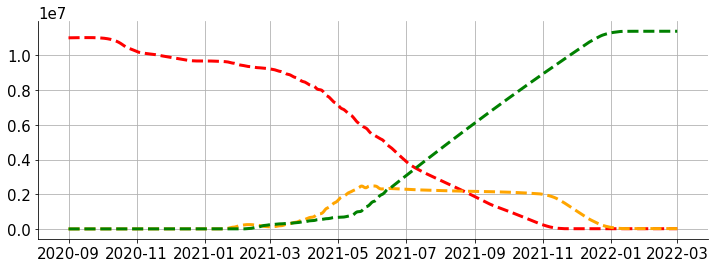

In [46]:
fig,ax = plt.subplots(figsize=(12,4))
simtime = out['time'].values
ax.plot(simtime,out['S'].sum(dim='Nc').mean(dim='draws').isel(doses=0), '--', color='red')
ax.plot(simtime,out['S'].sum(dim='Nc').mean(dim='draws').isel(doses=1), '--', color='orange')
ax.plot(simtime,out['S'].sum(dim='Nc').mean(dim='draws').isel(doses=2), '--', color='green')

Text(0, 0.5, '$H_{in}$ (-)')

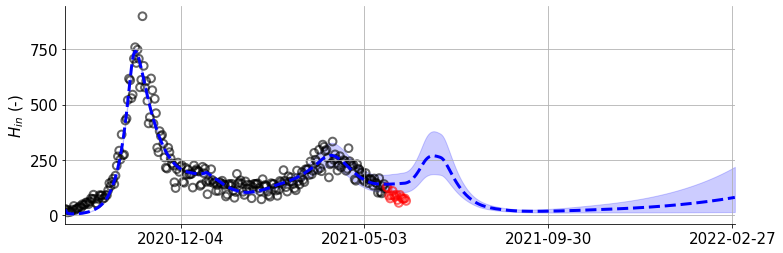

In [47]:
fig,ax = plt.subplots(figsize=(12,4))
simtime = out['time'].values
ax.plot(simtime,out['H_in'].sum(dim='Nc').sum(dim='doses').mean(dim='draws'), '--', color='blue')
ax.fill_between(simtime,out['H_in'].sum(dim='Nc').sum(dim='doses').quantile(dim='draws',q=0.025), out['H_in'].sum(dim='Nc').sum(dim='doses').quantile(dim='draws',q=0.975), color='blue', alpha = 0.20)
ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):], color='red', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
ax.set_ylabel('$H_{in}$ (-)')

NameError: name 'df_2plot' is not defined

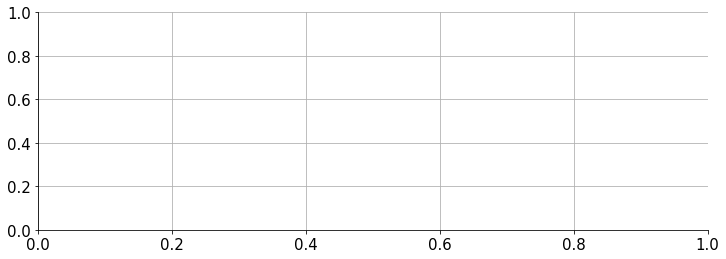

In [14]:
# -----------
# Visualizing
# -----------

fig,ax = plt.subplots(figsize=(12,4))
# Incidence
ax.plot(df_2plot['H_in','mean'],'--', color='blue')
ax.fill_between(simtime, df_2plot['H_in','LL'], df_2plot['H_in','UL'],alpha=0.20, color = 'blue')
ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):], color='red', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.axvspan(end_calibration, '2021-12-31', facecolor='0.2', alpha=0.15)
ax.text(x=end_calibration,y=840,s='EXTRAPOLATION', fontsize=16)
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
ax.set_ylabel('$H_{in}$ (-)')

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
# Incidence
ax.plot(df_2plot['H_tot','mean'],'--', color='blue')
ax.fill_between(simtime, df_2plot['H_tot','LL'], df_2plot['H_tot','UL'],alpha=0.20, color = 'blue')
ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_tot'][start_calibration:end_calibration], color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):].index,df_sciensano['H_tot'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):], color='red', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.axvspan(end_calibration, '2021-12-31', facecolor='0.2', alpha=0.15)
ax.text(x=end_calibration,y=7000,s='EXTRAPOLATION', fontsize=16)
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
ax.set_ylabel('$H_{tot}$ (-)')